In [1]:
# Re-run cleaned-up model setup after code execution reset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.special import legendre

# --- Constants ---
Omega     = 7.2921e-5
a         = 6.371e6
R         = 287.0
cp        = 1004.0
g         = 9.81
T_surface = 288.0
pb        = 1000e2
ptr       = 200e2
tau_E     = 5
tau_N     = 10
dt        = 0.25
n_days    = 25
n_steps   = int(n_days / dt)

# --- Grid ---
ny, nz  = 88, 20
lat_deg = np.linspace(0.5, 87.5, ny)
phi     = np.radians(lat_deg)
y       = a * phi
dy         = y[1] - y[0]
cosphi     = np.cos(phi)
cos2_phi   = cosphi**2
cos2_plus  = np.roll(cos2_phi, -1)
cos2_minus = np.roll(cos2_phi, 1)
f          = 2 * Omega * np.sin(phi)
f2         = f[None, :]**2

# p = np.linspace(pb, 1e2, nz)
p = np.linspace(pb, 0, nz)
p[-1] = 1

dp = p[1] - p[0]
P, PHI = np.meshgrid(p, phi, indexing='ij')



## Load Dycore data (regridded)

In [2]:
importdata = np.load('/home/pokemon/Codes/Annular_mode_eddy_closure/PeterChang-Dycore_data-PR0-PR0_500_20000day_6hourly_zonalmean_EMF_EHF_u_T_regrid.npz')
print(importdata.files)
for varName in importdata.files[:-1]:
    exec(varName + " = importdata[\"" + varName + "\"]")
    print(varName)


['EMF_bar', 'EHF_bar', 'u_bar', 't_bar', 'lat_regular', 'p']
EMF_bar
EHF_bar
u_bar
t_bar
lat_regular


In [3]:
#### select only the Northern-hemisphere
idx_NH = np.where(lat_regular > 0)[0]
lat_regular = lat_regular[idx_NH]

EMF_bar = EMF_bar[..., idx_NH]
EHF_bar = EHF_bar[..., idx_NH]
u_bar = u_bar[..., idx_NH]
t_bar = t_bar[..., idx_NH]

EMF_Dy = EMF_bar
EHF_Dy = EHF_bar
u_Dy = u_bar
T_Dy = t_bar

u_Dy_climatology = u_Dy.mean(axis = 0)
T_Dy_climatology  = T_Dy.mean(axis=0)

u_Dy_anomaly = u_Dy - u_Dy_climatology
T_Dy_anomaly = T_Dy - T_Dy_climatology

print(EMF_Dy.shape)
print(u_Dy.shape)

(78000, 20, 88)
(78000, 20, 88)


In [4]:
# --- Temperature and Stratification --- (need to be replaced by dycore data)
Gamma_trop = 6.0 / 1e3
delta_p = 50e2
Gamma_profile = Gamma_trop * 0.5 * (1 + np.tanh((P - ptr) / delta_p))
T_Rob = np.zeros_like(P)
T_Rob[0, :] = T_surface
for k in range(1, nz):
    dlogp   = np.log(p[k - 1] / p[k])
    Gamma_k = 0.5 * (Gamma_profile[k, :] + Gamma_profile[k - 1, :])
    dz      = R * T_Rob[k - 1, :] * dlogp / g
    T_Rob[k, :] = T_Rob[k - 1, :] - Gamma_k * dz

theta_Rob     = T_Rob * (pb / P) ** (R / cp)
dtheta_dp = np.gradient(theta_Rob, dp, axis=0)
sigma_Rob     = -(R * T_Rob / P) * (dtheta_dp / theta_Rob)
sigma_Rob     = np.clip(sigma_Rob, 1e-6, None)



## Define helper function

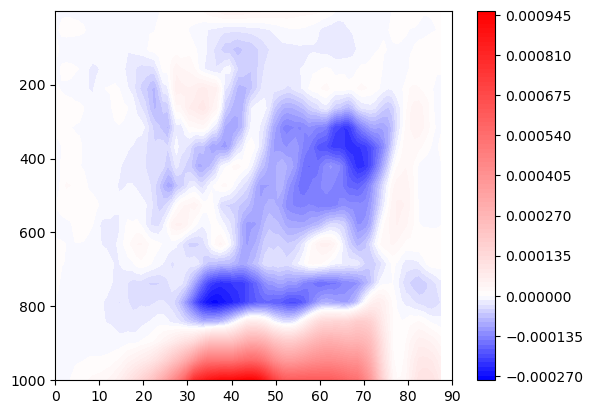

In [5]:
def uv_vT_to_vq(
    uv,            # EMF u'v'  (time, p, lat)
    vT,            # EHF v'T'  (time, p, lat)
    phi,               # latitude [rad], shape (lat,)
    P,                 # pressure [Pa]: shape (p,lat)
    sigma              # static stability σ: 1D/2D/3D like p
):

    cos_phi = np.cos(phi)[None, None, :]
    
    horiz_coeff = -1 / a / cos_phi
    horiz_deriv = np.gradient(cos_phi* uv, phi, axis = -1, edge_order=2)

    horiz_part = horiz_coeff* horiz_deriv


    sin_phi = np.sin(phi)[None, None, :]
    f = 2 * Omega * sin_phi
    
    vert_in_deriv = - (f * R) / (sigma * P) * vT
    vert_part = np.zeros_like(vT)
    
    for i in range(len(phi)):  # loop over latitudes
        vert_part[..., i] = np.gradient(vert_in_deriv[..., i], P[..., i], axis = 1, edge_order=2)

    return horiz_part + vert_part, horiz_part, vert_part

# --- Temperature and Stratification --- (replaced by dycore data)

theta_Dy     = T_Dy * (pb / P) ** (R / cp)
dtheta_dp = np.gradient(theta_Dy, dp, axis=1, edge_order=2)
sigma_Dy     = -(R * T_Dy / P) * (dtheta_dp / theta_Dy)
sigma_Dy     = np.clip(sigma_Dy, 1e-6, None)


vq_Dy, horiz_part, vert_part = uv_vT_to_vq(
    EMF_Dy,            # EMF u'v'  (time, p, lat)
    EHF_Dy,            # EHF v'T'  (time, p, lat)
    phi,               # latitude [rad], shape (lat,)
    P,                 # pressure [Pa]: 1D (p,), 2D (time,p), or 3D (time,p,lat)
    sigma_Dy              # static stability σ: 1D/2D/3D like p
)

#### Calculate climatology
vq_Dy_climatology = vq_Dy.mean(axis = 0)
sigma_Dy_climatology = sigma_Dy.mean(axis = 0)

#### Calculate anomaly
vq_Dy_anomaly = vq_Dy - vq_Dy_climatology


plt.contourf(lat_deg, p/100, vq_Dy[0], cmap = 'bwr', norm = TwoSlopeNorm(0), levels = 100)
plt.gca().invert_yaxis()
plt.xlim([0, 90])
plt.colorbar()

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#### Thermal wind relation through normal equation

# u_Dy_anomaly_flatten = u_Dy_anomaly.reshape(u_Dy_anomaly.shape[0], -1)
# T_Dy_anomaly_flatten = T_Dy_anomaly.reshape(T_Dy_anomaly.shape[0], -1)

# u_to_T = LinearRegression()
# u_to_T.fit(u_Dy_anomaly_flatten, T_Dy_anomaly_flatten)


u_Dy_flatten = u_Dy.reshape(u_Dy.shape[0], -1)
T_Dy_flatten = T_Dy.reshape(T_Dy.shape[0], -1)

# u_to_T = LinearRegression()
# u_to_T.fit(u_Dy_flatten, T_Dy_flatten)

# u_to_T = Lasso(alpha=0.01, max_iter=10000)
# u_to_T.fit(u_Dy_flatten, T_Dy_flatten)


u_to_T = Ridge(alpha=1.0)
u_to_T.fit(u_Dy_flatten, T_Dy_flatten)
# u_to_T.fit(u_Dy_anomaly_flatten, T_Dy_anomaly_flatten)



Ridge()

In [7]:
#### Calculate relative vorticity from zonal mean u wind ####

def u_to_zeta(ubar, phi):
    """ubar: [..., nlat] zonal-mean u [m s^-1]; phi: [nlat] in radius."""
    
    cos_phi = np.cos(phi).reshape((1,) * (ubar.ndim - 1) + (-1,))


    u_cos  = ubar * cos_phi  # broadcasts on the last axis
    d_ucos_dphi = np.gradient(u_cos, phi, axis=-1)

    zeta = - d_ucos_dphi / (a * cos_phi)  # [..., nlat]

    return zeta


In [8]:
from scipy.special import legendre
import numpy as np

def legendre_filter_mirrored(u, phi, lmax_keep=20):
    """
    Fast Legendre low-pass filter using matrix projection.

    Parameters:
    - u: shape (nz, ny), input field (e.g., zonal wind)
    - phi: shape (ny,), latitude in radians
    - lmax_keep: number of Legendre modes to keep

    Returns:
    - u_filtered: shape (nz, ny), filtered field
    """
    nz, ny = u.shape
    mu = np.sin(phi)

    # Mirror domain in μ
    mu_mirror = np.concatenate([-mu[::-1], mu])  # shape (2*ny,)
    ny_full = 2 * ny

    # Precompute Legendre basis matrix: shape (lmax+1, 2*ny)
    P = np.array([legendre(l)(mu_mirror) for l in range(lmax_keep + 1)])  # shape (lmax+1, 2*ny)

    # Normalize each row (orthogonal projection)
    norm = np.trapz(P**2, mu_mirror, axis=1)  # shape (lmax+1,)

    # Project and reconstruct
    u_filtered = np.zeros_like(u)
    for i in range(nz):
        u_mir = np.concatenate([u[i, ::-1], u[i, :]])  # shape (2*ny,)
        coeffs = np.trapz(P * u_mir[None, :], mu_mirror, axis=1) / norm  # shape (lmax+1,)
        u_rec = np.dot(coeffs, P)  # shape (2*ny,)
        u_filtered[i, :] = u_rec[ny:]  # take right half (original domain)

    return u_filtered

def vertical_relaxation_operator(u, sigma, dp, f2, tau_N):
    """
    Computes f^2 ∂p ( (1 / (τ σ)) ∂p u ) using centered differences.
    Assumes uniform dp.

    Parameters:
        u      : (nz, ny) array
        sigma  : (nz, ny) array
        dp     : scalar pressure spacing
        f2     : (1, ny) array
        tau_N  : scalar

    Returns:
        relax_term: (nz, ny) array
    """
    nz, ny = u.shape
    relax_term = np.zeros_like(u)

    inv_sigma = 1.0 / sigma
    coeff = f2 / tau_N / dp**2  # shape (1, ny)

    for k in range(1, nz - 1):
        inv_sigma_plus  = 0.5 * (inv_sigma[k, :] + inv_sigma[k+1, :])
        inv_sigma_minus = 0.5 * (inv_sigma[k, :] + inv_sigma[k-1, :])
        term_plus  = inv_sigma_plus  * (u[k+1, :] - u[k, :])
        term_minus = inv_sigma_minus * (u[k, :]   - u[k-1, :])
        relax_term[k, :] = coeff * (term_plus - term_minus)

    # Optional: boundary conditions (zero-flux Neumann)
    relax_term[0, :]  = 0
    relax_term[-1, :] = 0

    return relax_term



In [9]:

def polyfit_filter_area_weighted(u, dy, phi, deg=2):
    nz, ny = u.shape
    u_filtered = np.copy(u)
    x = np.arange(ny) * dy
    cosphi = np.cos(phi)

    for i in range(nz):
        yvals = u[i, 1:10]
        xvals = x[1:10]
        wvals = cosphi[1:10]
        coeffs = np.polyfit(xvals, yvals, deg=deg, w=wvals)
        u_filtered[i, 0] = np.polyval(coeffs, x[0])
        #u_filtered[i, 1] = np.polyval(coeffs, x[1])

        yvals = u[i, ny-10:-1]
        xvals = x[ny-10:-1]
        wvals = cosphi[ny-10:-1]
        coeffs = np.polyfit(xvals, yvals, deg=deg, w=wvals)
        u_filtered[i, -1] = np.polyval(coeffs, x[-1])

    return u_filtered



def laplacian_meridional_neumann_legendre_filtered(u, dy, cos2_phi, phi, legendre_order_cutoff=20):
    """
    Compute meridional Laplacian with Neumann BC via mirroring and Legendre filtering.

    Parameters:
    - u: shape (nz, ny)
    - dy: grid spacing in meters
    - cos2_phi: shape (ny,), cos²(φ)
    - phi: shape (ny,), latitude in radians
    - legendre_order_cutoff: number of Legendre modes to retain

    Returns:
    - lap_filtered: shape (nz, ny)
    """
    nz, ny = u.shape
    mu = np.sin(phi)
    ny_full = 2 * ny

    # Mirrored arrays
    u_mirrored = np.concatenate([u[:, ::-1], u], axis=1)  # shape (nz, 2*ny)
    cos2_full = np.concatenate([cos2_phi[::-1], cos2_phi])
    mu_mirror = np.concatenate([-mu[::-1], mu])  # shape (2*ny,)

    # Compute Laplacian on mirrored grid
    u_ext = np.pad(u_mirrored, ((0, 0), (1, 1)), mode='edge')  # (nz, 2*ny+2)
    cos2_ext = np.pad(cos2_full, (1, 1), mode='edge')          # (2*ny+2,)
    lap_full = (
        cos2_ext[2:] * u_ext[:, 2:] +
        cos2_ext[:-2] * u_ext[:, :-2] -
        (cos2_ext[2:] + cos2_ext[:-2]) * u_ext[:, 1:-1]
    ) / (dy**2 * cos2_ext[1:-1])  # shape (nz, 2*ny)

    # lap_full = (
    #     cos2_ext[2:] * u_ext[:, 2:] +
    #     cos2_ext[:-2] * u_ext[:, :-2] -
    #     (cos2_ext[2:] + cos2_ext[:-2]) * u_ext[1:-1]
    # ) / (dy**2 * cos2_ext[1:-1])  # shape (nz, 2*ny)

    # Precompute Legendre basis matrix (lmax+1, 2*ny)
    P = np.array([legendre(l)(mu_mirror) for l in range(legendre_order_cutoff + 1)])
    norm = np.trapz(P**2, mu_mirror, axis=1)  # (lmax+1,)

    # Project and reconstruct
    lap_filtered = np.zeros((nz, ny))
    for i in range(nz):
        lap_i = lap_full[i, :]
        coeffs = np.trapz(P * lap_i[None, :], mu_mirror, axis=1) / norm
        lap_rec = np.dot(coeffs, P)
        lap_filtered[i, :] = lap_rec[ny:]  # extract right half

    return lap_filtered

## Model settings

In [10]:
start_Dy = 77777#40

#################### Initial condition ####################
T = T_Dy_climatology.copy()
sigma = sigma_Dy_climatology.copy()

# ------------------ eddy source (Dycore) ------------------
vqb  = vq_Dy_anomaly[start_Dy,:,:].copy()*86400

vqb_surface = np.zeros_like(y) # surface forcing is currently turned off np.zeros_like(y.shape) #

d2vqb_dy2         = laplacian_meridional_neumann_legendre_filtered(vqb, dy, cos2_phi, phi, legendre_order_cutoff=20)
d2vqb_dy2_surface = laplacian_meridional_neumann_legendre_filtered(vqb_surface[None, :], dy, cos2_phi, phi, legendre_order_cutoff=20)

# ------------------ u (Dycore) ------------------
u  = u_Dy_anomaly[start_Dy,:,:].copy()
# u = np.zeros((nz, ny))
# u  = u_Dy[start_Dy,:,:].copy()



## Time integration ##

In [11]:

#################### other settings ####################
max_iter = 10000
tol      = 1e-5
no_progress_threshold = 1  # number of iterations allowed without error drop

robert_coef = 0.04
errors      = []
no_progress_counter = 1



#################### outputs ####################
u_evolution = np.zeros((n_steps, nz, ny))
T_evolution = np.zeros((n_steps, nz, ny))


# ------------------ climatology u --> relative vorticity ------------------
zeta = u_to_zeta(u_Dy_climatology, phi)
eta = f + zeta

# --- Time-stepping loop ---
for step in range(1):
    #### reset tendency term
    u_t      = np.zeros_like(u)
    u_t_new  = np.zeros_like(u)
    ####

    
    print('step='+str(step))
    T_b = T[0, :]
    sigma_b = sigma[0, :]
    u_b     = np.copy(u[0, :])

    du_relax_dp        = np.gradient(u / tau_N, dp, axis=0) # Newtonian cooling @boundary
    du_relax_dp_pb     = du_relax_dp[0, :]
    laplacian_ub       = np.zeros_like(u_b)[None,:]
    u_b                = polyfit_filter_area_weighted(u_b[None,:], dy, phi, deg=1)

    laplacian_ub[0,:]  = laplacian_meridional_neumann_legendre_filtered(u_b, dy, cos2_phi, phi, legendre_order_cutoff=20)

    
    ########### replace f with eta (absolute vorticity) #######
    rhs_total          = -d2vqb_dy2_surface + (pb / tau_E) * laplacian_ub - (eta[0, :]**2 / sigma_b) * du_relax_dp_pb
    ###########
    

    # for interior relaxation term
    relax_term = vertical_relaxation_operator(u, sigma, dp, f2, tau_N)

    for iteration in range(max_iter):
        for k in range(1, nz - 1):
            #u_t[:,0]   = u_t[:,1]
            sigma_plus  = 0.5 * (sigma[k + 1, :] + sigma[k, :])
            sigma_minus = 0.5 * (sigma[k - 1, :] + sigma[k, :])
            sigma_plus  = np.clip(sigma_plus, 1e-6, None)
            sigma_minus = np.clip(sigma_minus, 1e-6, None)

            u_j   = u_t[k, :]
            u_jp1 = np.roll(u_j, -1)
            u_jm1 = np.roll(u_j, 1)
            horiz = np.zeros_like(u_j)
            horiz[1:-1] = ((
                cos2_plus * u_jp1 +
                cos2_minus * u_jm1
            ) / (dy**2 * cos2_phi))[1:-1]
            # if k==1:
            #     plt.plot(horiz,'k.')
            #horiz = polyfit_filter_area_weighted(horiz[None,:],dy,phi,deg =3)
            # if (k==1) & (iteration==max_iter-1):
            #   plt.figure()
            #   plt.plot(horiz)

            vert = ((
                u_t[k - 1, :] / sigma_minus +
                u_t[k + 1, :] / sigma_plus
            ) * eta[k, :]**2 / dp**2)



            diag_vert  = eta[k, :]**2 / dp**2 * (1 / sigma_plus + 1 / sigma_minus)
            diag_merid = (cos2_plus + cos2_minus) / (dy**2 * cos2_phi)
            diag       = diag_merid + diag_vert

            rhs        = -relax_term[k, :] + d2vqb_dy2[k, :]
            # rhs[0]     = 0
            u_t_new[k, 1:-1] = ((vert - rhs + horiz) / diag)[1:-1]

            # if (k==1) & (iteration==max_iter-1):
            #     plt.plot(horiz)

        A = eta[0, :]**2 * pb / (R * T_b)
        B = eta[0, :]**2 / (sigma_b * dp)
        u_t_new[0, :]  = (rhs_total - B * u_t_new[1, :]) / (A - B)
        u_t_new[-1, :] = u_t_new[-2, :]
        # u_t_new[:,-1]  = 0
        u_t_new[0,0]   = 0
        u_t_new[0,:]   = legendre_filter_mirrored(u_t_new[0,:][None,:], phi, lmax_keep=4)
        # u_t_new        = polyfit_filter_area_weighted(u_t_new, dy, phi, deg=1)
        #
        # print(np.max(np.abs(u_t_new - u_t)))
        if np.max(np.abs(u_t_new - u_t)) < tol:
            break

        u_t[:, :] = u_t_new[:, :]

    # u_barotropic = -vqb.mean(axis=0)*tau_E # barotropic wind intensity
    # u_diff       = -(u[0,:] - u_barotropic)/tau_N
    # u_diff       = legendre_filter_mirrored(u_diff[None,:], phi, lmax_keep=3)
    # u_t[0,:]    += u_diff.squeeze
    
    
    u_step = u + u_t*dt

    u_total = u_step + u_Dy_climatology
    
    u_evolution[step] = u_total.copy()
    
    #### Predict T from u with thermal wind balance
    T_twb = u_to_T.predict((u_total).reshape(1, -1)).reshape(u.shape)

    T_evolution[step] = T_twb.copy()


step=0


Text(0.5, 1.0, 'Robinson model at t+1')

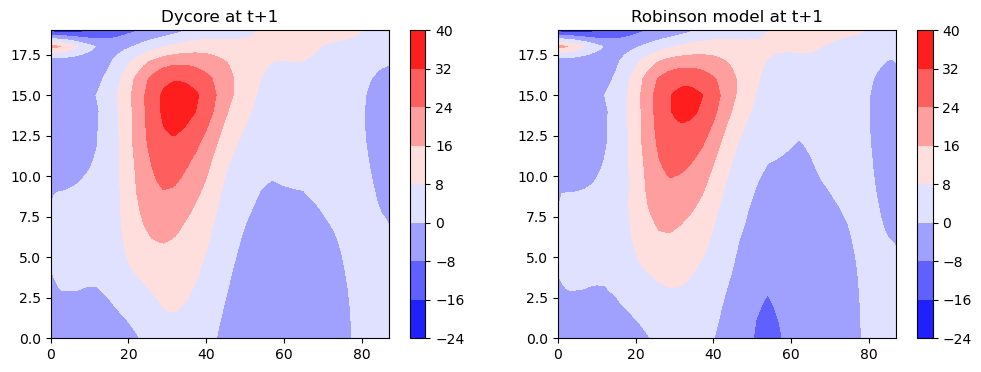

In [12]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.contourf(u_Dy[start_Dy + 1,:,:], cmap = 'bwr')
plt.colorbar()
plt.title('Dycore at t+1')


plt.subplot(1,2,2)
plt.contourf(u_total, cmap = 'bwr')
plt.colorbar()
plt.title('Robinson model at t+1')

